This notebook provides examples to go along with the [textbook](http://underactuated.csail.mit.edu/contact.html).  I recommend having both windows open, side-by-side!

[Click here](http://underactuated.csail.mit.edu/drake.html#notebooks) for instructions on how to run the notebook on Deepnote and/or Google Colab.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
from pydrake.all import DirectCollocation, MathematicalProgram, Solve
from pydrake.examples.rimless_wheel import RimlessWheel

from underactuated import FindResource, running_as_notebook


# Trajectory optimization for the Rimless Wheel


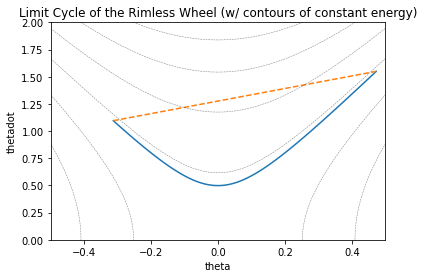

In [4]:
def rimless_wheel_limit_cycle():
    plant = RimlessWheel()
    context = plant.CreateDefaultContext()

    params = context.get_numeric_parameter(0)
    slope = params.slope()
    alpha = np.pi / params.number_of_spokes()

    dircol = DirectCollocation(plant,
                            context,
                            num_time_samples=15,
                            minimum_timestep=0.01,
                            maximum_timestep=0.1,
                            assume_non_continuous_states_are_fixed=True)
    prog = dircol.prog()

    dircol.AddEqualTimeIntervalsConstraints()

    dircol.AddConstraintToAllKnotPoints(dircol.state()[0] >= slope - alpha)
    dircol.AddConstraintToAllKnotPoints(dircol.state()[0] <= slope + alpha)

    prog.AddConstraint(dircol.initial_state()[0] == slope - alpha)
    prog.AddConstraint(dircol.final_state()[0] == slope + alpha)

    prog.AddConstraint(dircol.initial_state()[1] == dircol.final_state()[1]
                       * np.cos(2 * alpha))

    result = Solve(prog)
    assert result.is_success()

    x_trajectory = dircol.ReconstructStateTrajectory(result)

    x_knots = np.hstack([
        x_trajectory.value(t) for t in np.linspace(x_trajectory.start_time(),
                                                x_trajectory.end_time(), 100)
    ])

    fig, ax = plt.subplots()
    ax.plot(x_knots[0, :], x_knots[1, :])
    ax.plot([x_knots[0, 0], x_knots[0, -1]], [x_knots[1, 0], x_knots[1, -1]], "--")

    # Plot the energy contours.
    nq = 151
    nqd = 151
    mgl = params.mass() * params.gravity() * params.length()
    q = np.linspace(-0.5, 0.5, nq)
    qd = np.linspace(-.5, 2, nqd)
    Q, QD = np.meshgrid(q, qd)
    Energy = .5 * params.mass() * params.length()**2 * QD**2 + mgl * np.cos(Q)
    ax.contour(Q,
            QD,
            Energy,
            alpha=0.5,
            linestyles="dashed",
            colors="black",
            linewidths=0.5)

    ax.set_xlabel("theta")
    ax.set_ylabel("thetadot")
    ax.axis([-0.5, 0.5, 0, 2])
    ax.set_title("Limit Cycle of the Rimless Wheel (w/ contours of "
                "constant energy)")
    #display(mpld3.display())

rimless_wheel_limit_cycle()

# A simple basketball "bounce pass"

NameError: name 'mpld3' is not defined

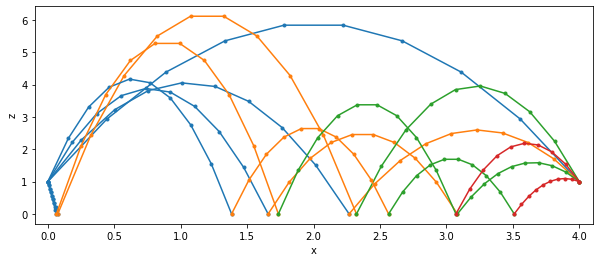

In [5]:
e = .8    # coefficient of restitution (0 ≤ e ≤ 1)
g = 9.8  # gravitational constant (m/s^2)
x0 = 0
xf = 4
z0 = 1
zf = 1

fig, ax = plt.subplots(figsize=(10,4))
ax.set_xlabel('x')
ax.set_ylabel('z')
ax.set_xlim(x0-.1, xf+.1)

def bounce_pass(number_of_bounces=0, zdot0_is_positive=True, debug=False):
    
    duration = 2+number_of_bounces
    xdot = (xf-x0)/duration
    prog = MathematicalProgram()
    h = prog.NewContinuousVariables(number_of_bounces+1, 'h')
    prog.AddConstraint(np.sum(h) == duration)
    prog.AddBoundingBoxConstraint(0, np.inf, h)
    
    # zdot at the start of each segment (after collision).
    zdot = prog.NewContinuousVariables(number_of_bounces+1, 'zd')

    # Initial velocity constraint (since we *might* have two solutions for each number of bounces)
    if (zdot0_is_positive):
        prog.AddBoundingBoxConstraint(0, np.inf, zdot[0])
    else:
        prog.AddBoundingBoxConstraint(-np.inf, 0, zdot[0])
    
    # Add dynamics constraints for each segment that ends with a bounce
    for i in range(number_of_bounces): 
        # z must be zero at the end of this segment:
        z = zdot[i]*h[i] - .5*g*h[i]*h[i] + (z0 if i==0 else 0)
        prog.AddConstraint(z == 0)
        prog.AddConstraint(zdot[i+1] == -e*(zdot[i] - h[i]*g))
        
    # Now the final segment
    z = zdot[-1]*h[-1] - .5*g*h[-1]*h[-1] + (z0 if number_of_bounces==0 else 0)
    prog.AddConstraint(z == zf)
    
    result = Solve(prog)
    if not result.is_success():
        if debug:
            infeasible = result.GetInfeasibleConstraints(prog)
            print("Infeasible constraints:")
            for i in range(len(infeasible)):
                print(infeasible[i])
        # return without plotting
        return

    # plot the resulting trajectory
    ax.set_prop_cycle(plt.rcParams['axes.prop_cycle']) # reset color cycle
    relative_time = np.linspace(0, 1, 10)
    x_start = x0
    for i in range(number_of_bounces+1):
        t = result.GetSolution(h[i])*relative_time
        x = x_start + t*xdot
        z = (z0 if i==0 else 0) + result.GetSolution(zdot[i])*t - .5*g*t*t
        ax.plot(x, z, '.-')
        x_start = x[-1]

#bounce_pass(number_of_bounces=2, zdot0_is_positive=False, debug=True)
for number_of_bounces in range(0,4):
    bounce_pass(number_of_bounces=number_of_bounces, zdot0_is_positive=True)
    bounce_pass(number_of_bounces=number_of_bounces, zdot0_is_positive=False)

display(mpld3.display())


# The basketball "trick shot"

Rotation rate during each segment:
[-48.90510626 -74.74551176 -19.74881645]


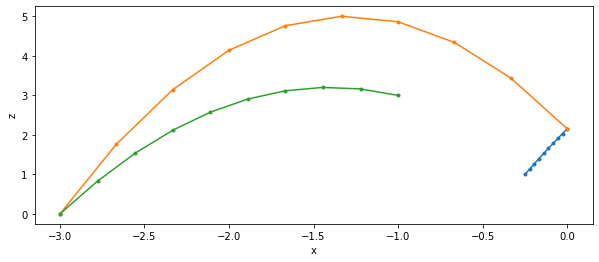

In [7]:
def trick_shot():
    m = 1.
    r = 0.1
    g = 9.8  # gravitational constant (m/s^2)
    e = .8    # coefficient of restitution (0 ≤ e ≤ 1)
    x0 = -.25
    xf = -1
    z0 = 1
    zf = 3

    N = 3
    prog = MathematicalProgram()
    h = prog.NewContinuousVariables(N)
    # Make sure time intervals are positive:
    prog.AddBoundingBoxConstraint(0.01, 10, h)
        
    # zdot at the start of each segment (after collision).
    xdot = prog.NewContinuousVariables(N)
    zdot = prog.NewContinuousVariables(N)
    thetadot = prog.NewContinuousVariables(N)

    # First segment -- from the launch to the wall.  
    # Implement the guard (x==0).
    prog.AddConstraint(x0 + h[0]*xdot[0] == 0).evaluator().set_description('x_wall')
    z = z0 + h[0]*zdot[0] - 0.5*g*h[0]*h[0]
    zdot_pre = zdot[0] - g*h[0]
    # integration + collision dynamics
    prog.AddConstraint(xdot[1] == -e * xdot[0]).evaluator().set_description('xdot_wall')
    prog.AddConstraint(zdot[1] == 3.*zdot_pre/5. - 2.*r*thetadot[0]/5.).evaluator().set_description('zdot_wall')
    prog.AddConstraint(thetadot[1] == -3*zdot_pre/(5.*r) + 2.*thetadot[0]/5.).evaluator().set_description('thetadot_wall')
    # Help it find the solution we want
    prog.AddConstraint(zdot[0] >= 0)
    prog.AddConstraint(thetadot[0] <= 0)

    # Second segment -- from wall to the floor
    z = z + zdot[1]*h[1] - 0.5*g*h[1]*h[1]
    # Implement the guard (z==0).
    prog.AddConstraint(z == 0).evaluator().set_description('z_floor')
    x = xdot[1]*h[1]
    zdot_pre = zdot[1] - g*h[1]
    # integration + collision dynamics
    prog.AddConstraint(xdot[2] == 3.*xdot[1]/5. - 2.*r*thetadot[1]/5.).evaluator().set_description('xdot_floor')
    prog.AddConstraint(zdot[2] == -e*zdot_pre).evaluator().set_description('zdot_floor')
    prog.AddConstraint(thetadot[2] == -3*xdot[1]/(5.*r) + 2.*thetadot[1]/5.).evaluator().set_description('thetadot_floor')
    # Make sure the ball doesn't travel too far away
    prog.AddConstraint(x >= -3.)

    # Final segment -- from the floor to the hoop
    x = x + xdot[2]*h[2]
    z = zdot[2]*h[2] - 0.5*g*h[2]*h[2]
    # make sure we end at the hoop.
    prog.AddConstraint(x == xf).evaluator().set_description('x_hoop')
    prog.AddConstraint(z == zf).evaluator().set_description('z_hoop')
    zdot_final = zdot[2] - g*h[2]
    # make sure we're approaching from the correct direction.
    prog.AddConstraint(xdot[2] >= .1).evaluator().set_description('xdot_hoop')
    prog.AddConstraint(zdot_final <= -2).evaluator().set_description('zdot_hoop')

    result = Solve(prog)
    if not result.is_success():
        infeasible = result.GetInfeasibleConstraints(prog)
        print("Infeasible constraints:")
        for i in range(len(infeasible)):
            print(infeasible[i])

        # plot the resulting trajectory
    fig, ax = plt.subplots(figsize=(10,4))
    ax.set_xlabel('x')
    ax.set_ylabel('z')
    #ax.set_xlim(x0-.1, xf+.1)
    ax.set_prop_cycle(plt.rcParams['axes.prop_cycle']) # reset color cycle
    relative_time = np.linspace(0, 1, 10)
    x_start = x0
    z_start = z0
    for i in range(N):
        t = result.GetSolution(h[i])*relative_time
        x = x_start + result.GetSolution(xdot[i])*t
        z = z_start + result.GetSolution(zdot[i])*t - .5*g*t*t
        ax.plot(x, z, '.-')
        x_start = x[-1]
        z_start = z[-1]
        
    print('Rotation rate during each segment:')
    print(result.GetSolution(thetadot))
    #display(mpld3.display())

trick_shot()